# Foundations of Computational Economics #36

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Simulating data from the model

<img src="_static/img/lab.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/eCQY1S6HJ58](https://youtu.be/eCQY1S6HJ58)

Description: Random variables induced by the model. Coin flipping example. Simulating consumption and wealth paths from the consumption-savings model.

### Stochastic model as random variable

$$
\tilde{X} \sim F_{\tilde{X}}(x)
$$

- distributions directly available in modules `random`, `NumPy.random` and `SciPy.stat`  
- inverse transform sampling to simulated from any cdf  


$$
\tilde{X} = M(\tilde{\varepsilon}), \tilde{\varepsilon} \sim F_{\varepsilon}(x)
$$

- $ M(\cdot) $ is the structure of the model  
- $ \tilde{\varepsilon} $ is the vector of random components in the model (“shocks”)  

#### Example: simulating Markov chains

- $ M(\cdot) $ is given by the transition probability matrix $ P $  
- $ \tilde{\varepsilon} $ can be though of the vector of standard uniform random variables $ U[0,1] $  
- for given initial state $ x_0 $, use the appropriate row of the matrix $ P $ to simulate $ x_1 $  
- for given state $ x_i $, use the appropriate row of the matrix $ P $ to simulate $ x_{i+1} $, and continue so forth for a given number of steps  


(see video 20)

#### More interesting example: coin flipping game

- fair coin is flipped sequentially  
- if 3 heads come up in a row, pay \$10  
- if 3 tails come up in a row, get \$10  


What is the distribution of the wins after 100 coin flips?

What is the expected number of tosses to win or loose \$100?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
def game(p=0.5,nsteps=10,stopping=None,verbose=False):
    '''3 tails coin flipping game'''
    i, tails, heads, balance = 1, 0, 0, [0.]  # initialize all indicators and counters
    while True:
        coin = np.random.random() > p  # draw from U[0,1)
        if verbose:
            print('T' if coin else 'H',end=' ')
        # increment the counters of consecutive heads/tails
        tails = tails + 1 if coin else 0
        heads = heads + 1 if not coin else 0
        i+=1
        if tails == 3 or heads == 3:
            increment = 10 if tails == 3 else -10
            balance.append(balance[-1] + increment)
            heads, tails = 0, 0   # four heads or tails should not count two series of three
            if verbose:
                print('($%1.0f)'%balance[-1],end=' ')
        else:
            balance.append(balance[-1])
        if nsteps and i >= nsteps:
            if verbose:
                print('Done after %d steps'%nsteps)
            break
        if stopping and (balance[-1] <= stopping[0] or balance[-1] >= stopping[1]):
            if verbose:
                print('Done after hitting the boundary')
            break
    return balance[-1], balance, i

In [3]:
b,bb,st = game(verbose=True)
# b,bb,st = game(verbose=True,stopping=(-30,100),nsteps=None)
print('Balance $%1.1f after %d coin flips'%(b,st))

T H T T H T H T T Done after 10 steps
Balance $0.0 after 10 coin flips


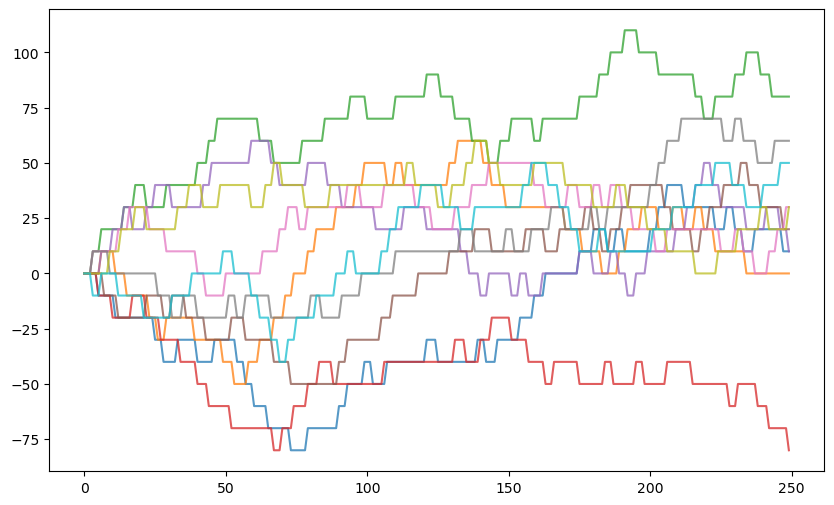

In [4]:
data = [game(nsteps=250) for i in range(10)]
fig, ax = plt.subplots(figsize=(10,6))
for balance,trajectory,rounds in data:
    plt.plot(range(rounds),trajectory,alpha=0.75)
plt.show()

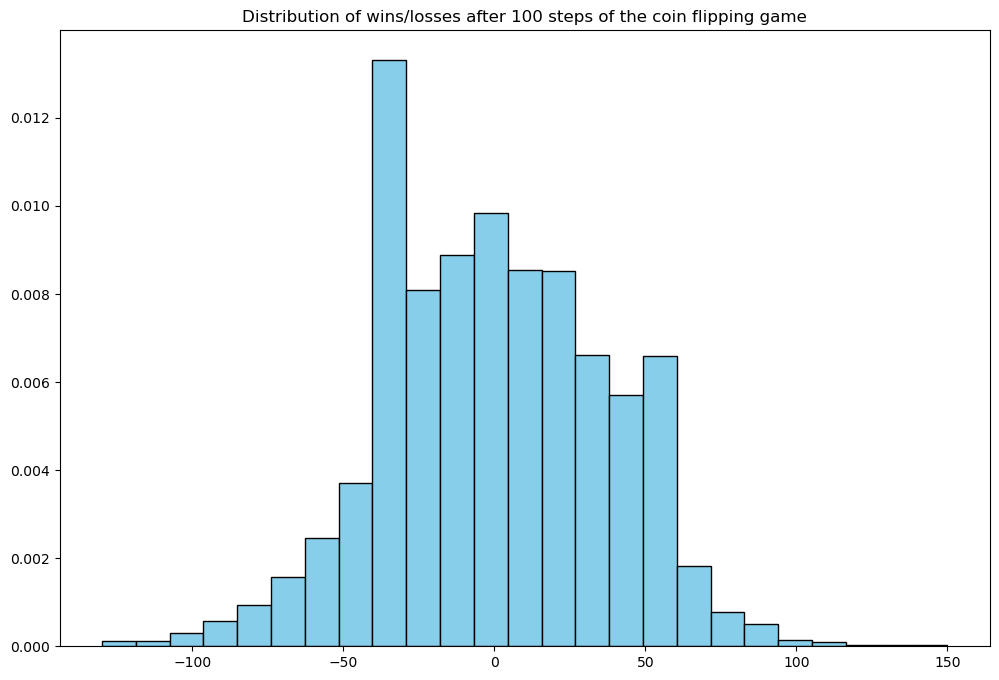

In [5]:
data = [game(nsteps=100) for i in range(5000)]
balances = [i for i,j,k in data]
plt.hist(balances,bins=25,density=True,color='skyblue',edgecolor='k')
plt.title('Distribution of wins/losses after 100 steps of the coin flipping game')
plt.show()

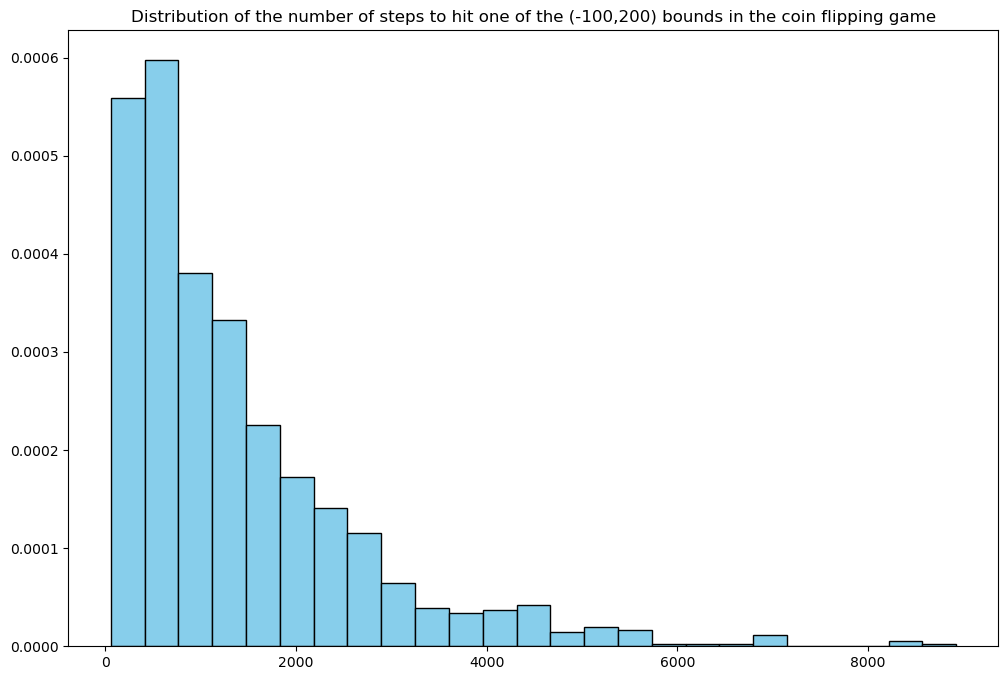

In [6]:
data = [game(nsteps=None,stopping=(-100,200)) for i in range(1000)]
rounds = [k for i,j,k in data]
plt.hist(rounds,bins=25,density=True,color='skyblue',edgecolor='k')
plt.title('Distribution of the number of steps to hit one of the (-100,200) bounds in the coin flipping game')
plt.show()

### Simulating from dynamic models

General form of the Bellman equation/operator

$$
V(\text{state}) = \max_{\text{decisions}} \big[ U(\text{state},\text{decision}) + \beta \mathbb{E}\big\{ V(\text{next state})  \big| \text{state},\text{decision} \big\} \big]
$$

Without loss of generality express the next period state is a function of shocks $ g(\text{state},\text{decision},\text{shocks}) = g(x,d,\tilde{\varepsilon}) $

$$
V(x) = \max_{d} \big[ U(x,d) + \beta \mathbb{E}_{\varepsilon}\big\{ V\big( g(x,d,\tilde{\varepsilon}) \big) \big\} \big] = T(V)(x)
$$

#### Solution of the model and simulation from the model

- Solution for the dynamic model: value function $ V^\star(x) $ satisfying the fixed point condition $ V(x)=T(V)(x) $  AND the policy function  


$$
d^\star(x) = \arg\max_{d} \big[ U(x,d) + \beta \mathbb{E}_{\varepsilon}\big\{ V^\star\big( g(x,d,\tilde{\varepsilon}) \big) \big\} \big]
$$

- After the model is solved for $ d^\star(x) $, $ \tilde{X} = M(\tilde{\varepsilon}), \tilde{\varepsilon} \sim F_{\varepsilon}(x) $ applies  
- $ \tilde{X} = \{x_0,\tilde{x}_1,\dots,\tilde{x}_T\} $ is the simulated state trajectory (for a given $ x_0 $ and $ T $)  
- $ \tilde{\varepsilon}  = \{\tilde{\varepsilon}_1,\dots,\tilde{\varepsilon}_T\} $ is a series of shocks, and it holds  


$$
\tilde{x}_t = g \big( \tilde{x}_{t-1},d^\star(\tilde{x}_{t-1}),\tilde{\varepsilon}_t \big)
$$

#### The difference between solution and simulation from the dynamic model

1. **Solution:** fixed point of the Bellman operator value function $ V^\star(x) $ and the policy function $ d^\star(x) $  
1. **Simulation:** a sequence of $ T $ realized points in the state space starting from the initial point $ x_0 $ **under the optimal policy**  


$$
\tilde{x}_t = g\big( \tilde{x}_{t-1},d^\star(\tilde{x}_{t-1}),\tilde{\varepsilon}_t \big)
$$

#### Simulating data from the stochastic consumption-savings model

Write the **simulator** (simulation function) for the stochastic consumption-savings model for:

- given vector of $ N $ initial state points $ M_0 = (M^1_0,\dots,M^N_0) $  
- simulate optimal consumption choices and state transitions on each of the $ N $ trajectories for $ T $ periods  
- make simulations repeatable by fixing the seed of the random number generator  

#### Simulator algorithm

1. Solve the model to find the policy function  
1. Initialize the simulated paths, fix the seed if required  
1. Loop for $ T $ periods, computing the optimal consumption choices and simulating random incomes  

In [7]:
# Developed in the video
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import lognorm

class deaton():
    '''Implementation of the stochastic Deaton consumption-savings problem with random income.'''

    def __init__(self, Mbar=10,
                 ngrid=50, nchgrid=100, nquad=10, interpolation='linear',
                 beta=.9, R=1.05, sigma=1.):
        '''Object creator for the stochastic consumption-savings model'''
        self.beta = beta        # Discount factor
        self.R = R              # Gross interest
        self.sigma = sigma      # Param in log-normal income distribution
        self.Mbar = Mbar        # Upper bound on wealth
        self.ngrid = ngrid      # Number of grid points in the state space
        self.nchgrid = nchgrid  # Number of grid points in the decision space
        self.nquad = nquad      # Number of quadrature points
        self.interpolation = interpolation  # type of interpolation, see below
        # state and choice space grids, as well as quadrature points and weights are set with setter functions below

    def __repr__(self):
        '''String representation for the model'''
        return 'Deaton model with beta={:1.3f}, sigma={:1.3f}, gross return={:1.3f}\nGrids: state {} points up to {:1.1f}, choice {} points, quadrature {} points\nInterpolation: {}\nThe model is {}solved.'\
               .format(self.beta,self.sigma,self.R,self.ngrid,self.Mbar,self.nchgrid,self.nquad,self.interpolation,'' if hasattr(self,'solution') else 'not ')

    @property
    def ngrid(self):
        '''Property getter for the ngrid parameter'''
        return self.__ngrid

    @ngrid.setter
    def ngrid(self,ngrid):
        '''Property setter for the ngrid parameter'''
        self.__ngrid = ngrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.grid = np.linspace(epsilon,self.Mbar,ngrid) # grid for state space

    @property
    def nchgrid(self):
        '''Property getter for the nchgrid parameter'''
        return self.__nchgrid

    @nchgrid.setter
    def nchgrid(self,nchgrid):
        '''Property setter for the nchgrid parameter'''
        self.__nchgrid = nchgrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.chgrid = np.linspace(epsilon,self.Mbar,nchgrid) # grid for state space

    @property
    def sigma(self):
        '''Property getter for the sigma parameter'''
        return self.__sigma

    @sigma.setter
    def sigma(self,sigma):
        '''Property setter for the sigma parameter'''
        self.__sigma = sigma
        self.__quadrature_setup()  # update quadrature points and weights

    @property
    def nquad(self):
        '''Property getter for the number of quadrature points'''
        return self.__nquad

    @nquad.setter
    def nquad(self,nquad):
        '''Property setter for the number of quadrature points'''
        self.__nquad = nquad
        self.__quadrature_setup()  # update quadrature points and weights

    def __quadrature_setup(self):
        '''Internal function to set up quadrature points and weights,
        depends on sigma and nquad, therefore called from the property setters
        '''
        try:
            # quadrature points and weights for log-normal distribution
            self.quadp,self.quadw = np.polynomial.legendre.leggauss(self.__nquad) # Gauss-Legendre for [-1,1]
            self.quadp = (self.quadp+1)/2 # rescale to [0,1]
            self.quadp = lognorm.ppf(self.quadp,self.__sigma) # inverse cdf
            self.quadw /= 2 # rescale weights as well
            self.quadp.shape = (1,1,self.__nquad)  # quadrature points in third dimension of 3-dim array
        except(AttributeError):
            # when __nquad or __sigma are not yet set
            pass

    def utility(self,c):
        '''Utility function'''
        return np.log(c)

    def next_period_wealth(self,M,c,y=None):
        '''Next period budget, returned for all quadrature points'''
        M1 = self.R*(M-c)                 # next period wealth without income
        if np.any(y==None):
            M1.shape += (1,)*(3-M1.ndim)  # add singular dimensions up to 3
            # interpolating over income ==> replace with quadrature points
            if self.nquad>1:
                return M1 + self.quadp    # 3-dim array
            else:
                return M1                 # special case of no income
        else:                             # needed for simulated income
            if self.nquad>1:
                return M1 + y
            else:
                return M1                 # special case of no income

    def interp_func(self,x,f):
        '''Returns the interpolation function for given data'''
        if self.interpolation=='linear':
            return interpolate.interp1d(x,f,kind='slinear',fill_value="extrapolate")
        elif self.interpolation=='quadratic':
            return interpolate.interp1d(x,f,kind='quadratic',fill_value="extrapolate")
        elif self.interpolation=='cubic':
            return interpolate.interp1d(x,f,kind='cubic',fill_value="extrapolate")
        elif self.interpolation=='polynomial':
            p = np.polynomial.polynomial.polyfit(x,f,self.ngrid_state-1)
            return lambda x: np.polynomial.polynomial.polyval(x,p)
        else:
            print('Unknown interpolation type')
            return None

    def bellman_discretized(self,V0):
        '''Bellman operator with discretized choice,
           V0 is 1-dim vector of values on the state grid
        '''
        states = self.grid[np.newaxis,:]                # state grid as row vector
        choices = self.chgrid[:,np.newaxis]             # choice grid as column vector
        M = np.repeat(states,self.nchgrid,axis=0)       # current wealth, state grid in columns (repeated rows)
        c = np.repeat(choices,self.ngrid,axis=1)        # choice grid in rows (repeated columns)
        c *= self.grid/self.Mbar                        # scale values of choices to ensure c<=M
        M1 = self.next_period_wealth(M,c)               # 3-dim array with quad point in last dimension
        inter = self.interp_func(self.grid,V0)          # interpolating function for next period value function
        V1 = inter(M1)                                  # value function at next period wealth, 3-dim array
        EV = np.dot(V1,self.quadw)                      # expected value function, 2-dim matrix
        MX = self.utility(c) + self.beta*EV             # maximand of Bellman equation, 2-dim matrix
        MX[c>M] = -np.inf                               # infeasible choices should have -inf (just in case)
        V1 = np.amax(MX,axis=0,keepdims=False)          # optimal choice as maximum in every column, 1-dim vector
        c1 = c[np.argmax(MX,axis=0),range(self.ngrid)]  # choose the max attaining levels of c
        return V1, c1

    def solve_vfi (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using value function iterations (successive approximations of Bellman operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        V0 = self.utility(self.grid) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1 = self.bellman_discretized(V0)
            err = np.amax(np.abs(V1-V0))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            V0 = V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        self.solution = {'value':V1,'policy':c1}  # save the model solution to the object
        return V1,c1

    def solve_plot(self,solver,**kvarg):
        '''Illustrate solution
           Inputs: solver (string), and any inputs to the solver
        '''
        if solver=='vfi':
            solver_func = self.solve_vfi
        else:
            raise ValueError('Unknown solver label')
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_title('Value function convergence with %s'%solver)
        ax2.set_title('Policy function convergence with %s'%solver)
        ax1.set_xlabel('Wealth, M')
        ax2.set_xlabel('Wealth, M')
        ax1.set_ylabel('Value function')
        ax2.set_ylabel('Policy function')
        def callback(**kwargs):
            print('|',end='')
            grid = kwargs['model'].grid
            v = kwargs['value']
            c = kwargs['policy']
            ax1.plot(grid[1:],v[1:],color='k',alpha=0.25)
            ax2.plot(grid,c,color='k',alpha=0.25)
        V,c = solver_func(callback=callback,**kvarg)
        # add solutions
        ax1.plot(self.grid[1:],V[1:],color='r',linewidth=2.5)
        ax2.plot(self.grid,c,color='r',linewidth=2.5)
        plt.show()
        return V,c

    def simulator(self,init_wealth=1,T=10,seed=None,plot=True):
        '''Simulation of the model for given number of periods from given initial conditions'''
        assert hasattr(self,'solution'), 'Need to solve the model before simulating!'
        if seed!=None:
            np.random.seed(seed)  # fix the seed if needed
        init_wealth = np.asarray(init_wealth).ravel()  # flat np array of initial wealth
        N = init_wealth.size  # number of trajectories to simulate
        sim = {'M':np.empty((N,T+1)),'c':np.empty((N,T+1))}
        sim['M'][:,0] = init_wealth  # initial wealth in the first column
        inter = self.interp_func(self.grid,self.solution['policy'])  # interpolation function for policy function
        for t in range(T+1):
            sim['c'][:,t] = inter(sim['M'][:,t])  # optimal consumption in period t
            if t<T:
                y = lognorm.rvs(self.sigma,size=N) # draw random income
                sim['M'][:,t+1] = self.next_period_wealth(sim['M'][:,t],sim['c'][:,t],y) # next period wealth
        if plot:
            fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
            ax1.set_title('Simulated wealth and consumption trajectories')
            ax1.set_ylabel('Wealth')
            ax2.set_ylabel('Consumption')
            ax2.set_xlabel('Time period in the simulation')
            for ax in (ax1,ax2):
                ax.grid(b=True, which='both', color='0.95', linestyle='-')
            for i in range(N):
                ax1.plot(sim['M'][i,:],alpha=0.75)
                ax2.plot(sim['c'][i,:],alpha=0.75)
            plt.show()
        return sim # return simulated data

Deaton model with beta=0.800, sigma=0.200, gross return=1.050
Grids: state 100 points up to 10.0, choice 250 points, quadrature 10 points
Interpolation: linear
The model is not solved.


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

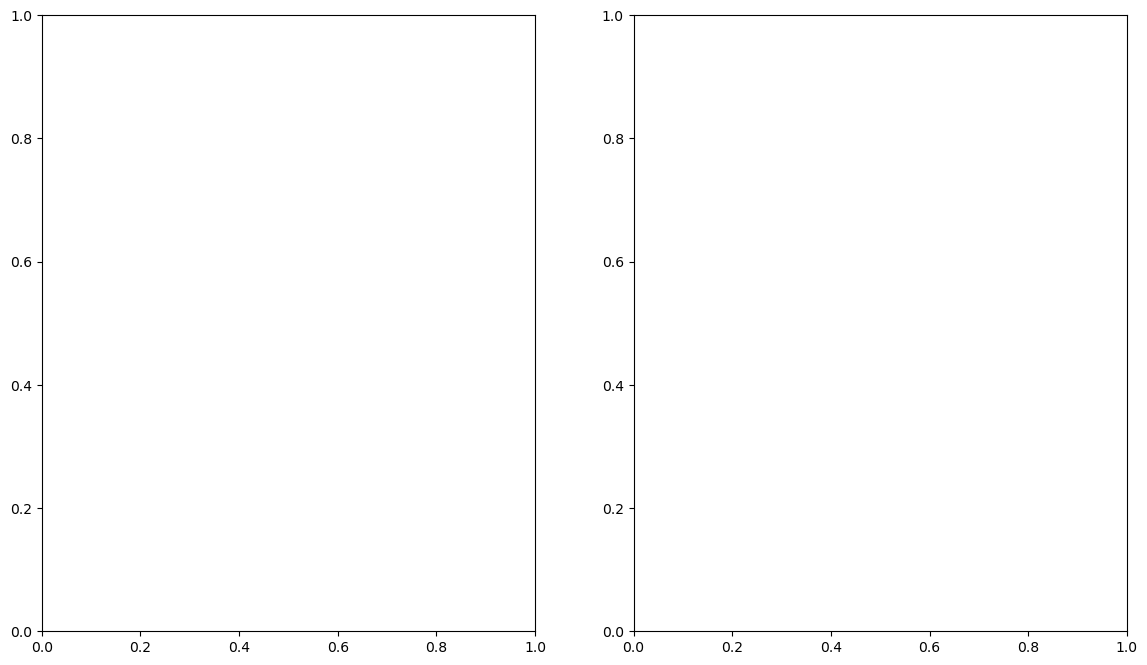

In [8]:
m = deaton(ngrid=100,nchgrid=250,sigma=.2,R=1.05,beta=.8,nquad=10)
print(m)
v,c = m.solve_plot(solver='vfi')
sims = m.simulator(init_wealth=[1,2,3],T=5)

#### Changes in the class deaton()

- save the solution in the object, update the `__repr__()` method to indicate if the model is solved  
- make sure the next period budget can be computed with simulated income  
- new `simulator()` method  
- plotting the simulations  

Deaton model with beta=0.850, sigma=0.200, gross return=1.050
Grids: state 100 points up to 10.0, choice 250 points, quadrature 10 points
Interpolation: linear
The model is solved.


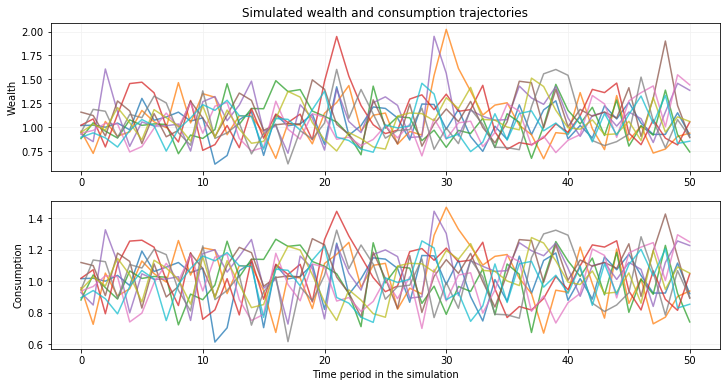

In [ ]:
# Previously developed simulator code (that requires the changes to the deaton() class!)

def simulator(self, init_wealth=1, T=10, seed=None, plot=True):
    '''Simulator for T periods of the model, init_wealth = initial wealth'''
    if self.solution is None:
        raise(RuntimeError('Model has to be solved before simulations'))
    if seed:
        np.random.seed(seed) # fix the seed in needed
    interp = self.interp_func(self.grid,self.solution['policy']) # interpolator of the policy function
    init_wealth = np.asarray(init_wealth).ravel() # initial wealth as flat np array
    N = init_wealth.size  # number of individuals to simulate
    sim = {'M': np.empty((N,T+1),dtype='float'),
           'c': np.empty((N,T+1),dtype='float'),
           'y': np.empty((N,T+1),dtype='float'),
          }  # dictionary to hold the simulated values
    sim['M'][:,0] = init_wealth # initialize wealth in first period
    sim['y'][:,0] = np.full(N,np.NaN) # no income in the first period
    for t in range(T+1):
        sim['c'][:,t] = interp(sim['M'][:,t]) # optim consumption
        if t < T: # until the last period
            sim['y'][:,t+1] = np.random.lognormal(sigma=self.sigma,size=N)
            sim['M'][:,t+1] = self.next_period_wealth(sim['M'][:,t],sim['c'][:,t],sim['y'][:,t+1])
    self.sims = sim  # save simulation into the object
    if plot:
        N = self.sims['M'].shape[0] # number of simulated agents
        fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
        ax1.set_title('Simulated wealth and consumption trajectories')
        ax1.set_ylabel('Wealth')
        ax2.set_ylabel('Consumption')
        ax2.set_xlabel('Time period in the simulation')
        for ax in (ax1,ax2):
            ax.grid(b=True, which='both', color='0.95', linestyle='-')
        for i in range(N):
            ax1.plot(sim['M'][i,:],alpha=0.75)
            ax2.plot(sim['c'][i,:],alpha=0.75)
        plt.show()
    return sim

m = deaton(ngrid=100,nchgrid=250,sigma=.2,R=1.05,beta=.85,nquad=10)
v,c = m.solve_vfi()
print(m)

# generate initial wealth
init_wealth = np.random.lognormal(sigma=.1,size=10)
# init_wealth = .85*np.ones(shape=5)
simulator(m,init_wealth=init_wealth,T=50);
# print('\nSimulated wealth:\n',m.sims['M'])
# print('\nSimulated consumption:\n',m.sims['c'])
# print('\nIncome realizations:\n',m.sims['y'])

#### More simulations

- Longer horizon, many people  
- Change sigma parameter in the model  
- Observe tendency to consumption smoothing  

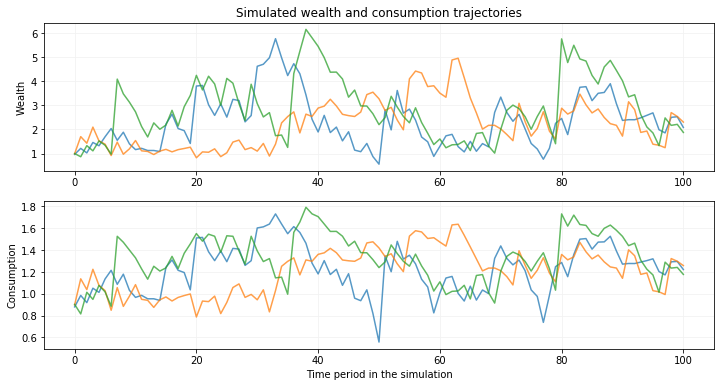

{'M': array([[0.96416167, 1.21328913, 1.02602714, 1.45947934, 1.32219227,
         1.69577937, 2.037419  , 1.5481308 , 1.88460115, 1.40065381,
         1.16221919, 1.21493393, 1.1253675 , 1.1257574 , 1.08320837,
         2.22150035, 2.63240775, 2.03734889, 1.94949815, 1.41787821,
         3.80253946, 3.82716709, 3.02559912, 2.58351668, 3.06317915,
         2.51189262, 3.24945661, 3.20053623, 2.31502133, 2.57736614,
         4.62272335, 4.70795558, 4.97934873, 5.76980662, 4.97677434,
         4.23772352, 4.73154005, 4.31186018, 3.43692443, 2.42336767,
         1.89507979, 2.58509517, 1.87114393, 2.09761213, 1.52512991,
         1.90355965, 1.14117255, 1.07630129, 1.41866503, 0.87257058,
         0.55814673, 2.81302204, 1.98191706, 3.61912165, 2.67814359,
         2.84379087, 2.38773647, 1.68431005, 1.48794416, 0.88052901,
         1.29770632, 1.73365949, 1.79623326, 1.28510188, 1.06722655,
         1.50474152, 1.0926077 , 1.4124716 , 1.27687566, 2.70773448,
         3.34342197, 2.706147

In [ ]:
m = deaton(R=1.05,beta=.925,nquad=7,sigma=0.5)
m.solve_vfi(maxiter=500)
# m.simulator(T=100,init_wealth=np.random.lognormal(sigma=0.1,size=3))
simulator(m,T=100,init_wealth=np.random.lognormal(sigma=0.1,size=3),plot=True)